# Simulating the NuSTAR telescope with AstroX/McXtrace using the McStasScript python package
This is a demo exercise showing how to build a telescope form a set of datafiles and dynamically build a 
simulation of the NuSTAR telescope.

## Introduction
Some brief remarks about the software pieces we will be using below

### McXtrace
McXtrace is a general, modular open source engine for Monte Carlo X-ray tracing, originally designed for synchrotron- and XFEL instrumentation (and experiment) simulations. It can equally well be used for telescopes provided the appropriate optical elements exist. McXtrace has been around for approximately 10 yrs, and is in use at large scale facilities world wide.

McXtrace distinguishes between an instrument and components. An instrument is a set of components placed in a geometry. A component can be thought of as a device, that interacts with the X-rays intersecting it. Interaction is in a broad sense of the word. For instance, a monitor is a type of component that merely measures some property of the X-ray, without influencing it.


### AstroX
AstroX is an add-on toolbox to McXtrace. Specifically it is a collection of component definitions, example instruments, and datafiles, catering to the X-ray astronomical telescope optics community. The toolbox includes optical components to build various variants of Wolter type optical telescopes. The most basic building block is the `Shell` which is a single full-circle mirror with either a parabolic, hyperbolic, or conical longitudinal geometrical profile. Derived from the `Shell` are set of other components:

* `Pore`: A walled segment of a Shell
* `Ring`: A stack of identical Shells
* `MM`: A mirror module, which concists of a collection of Pores stacked both radially and azimuthally. This is the basic optical block for SPO-based telescopes such as the planned ATHENA mission.

In addition, AstroX includes a module for simulating Lobster-eye optics: MCP, for such geometries as BEPI-COLOMBO.

### McStasScript
McStasScript is developed under the EU-project PanOSC as a flexible, python interface to the widely used McStas software package for neutron Monte Carlo ray-tracing. Lately, it also supports running McXtrace by setting a small set of configuration flags at the top of the simulation script.

One of the main features of McStasScript is the ability to use pythons built-in list and iteration facilities to loop over sets. This is useful when a (large) set of similar objects need to be added to a McXtrace/McStas. Using the standard interface this tends bo either tedious, error-prone, or both. For telescope optics applications it is often the case that a large set of similar objects is to be included.

An additional bonus is that connecting to python libraries alongside ray tracing simulations becomes simple, for instance for data-analysis.


## Setting up the simulation

Here we will first add some boilerplate code to let our notebook use AstroX/McXtrace and McStas. In this case I rely on it being available locally.


### Importing packages necessary for McXtrace simulations
First the McStasScript package is imported, and configured to use McXtrace instead of the default McStas (which would ray-trace neutrons instead of X-ray photons)

In this case I simply amend the system path to include also the directory where McStasScript resides.

In [ ]:
import sys
sys.path.append('/home/erkn/Repositories/McStasScript')
from mcstasscript.interface import instr, functions, plotter,reader

myconfig = functions.Configurator()
myconfig.set_mxrun_path("/usr/bin")
myconfig.set_mcxtrace_path("/usr/share/mcxtrace/1.5/")
myconfig.set_line_length(120)

### Setting up the instrument
Here an instrument object is created. All the files related to this instrument will be placed in the run_folder which must already exist. If no input_path is specified, the current directory will be used.

In [ ]:
#instantiate the instrument
NuSTAR = instr.McXtrace_instr("NuSTAR", input_folder="run_folder")

We want to be able to change the energy of the impinging radiation in our simulation, so we add parameters to this effect. Such parameters may be changed dynamically, and even varied as part of a simulation run as a pointwise scan.

In [ ]:
#add instrument parameters
NuSTAR.add_parameter("double","E0",value=40,comment="Central energy to simulate [keV]")
NuSTAR.add_parameter("double","dE", value=39.99, comment="Half width of energy range to simulate [keV]")

### Reading the input files
In this section we read a set of datafiles which contain the geometry of the mirrors in the NuSTAR telescope. The datafiles contain specifically the midpoint radii and coatings (through an index) of the Wolter optic for the 133 mirror shells. As an example we list the first 6 lines of the datafile ```m_con_1a_110901_11.txt```.
```
#                   R1                   R2                   Z1                   Z2         MIRROR_ANGLE              MLENGTH               MTHICK      COATING                 RB1I                 RB1O                 RB2I                 RB2O                 ZB1I                 ZB1O                 ZB2I                 ZB2O
#                   1D                   1D                   1D                   1D                   1D                   1D                   1D           1J                   1D                   1D                   1D                   1D                   1D                   1D                   1D                   1D
#                   mm                   mm                   mm                   mm                  rad                   mm                   mm                                mm                   mm                   mm                   mm                   mm                   mm                   mm                   mm
   5.456900000000E+01   5.426700000000E+01   1.125000000000E+02  -1.125000000000E+02   1.340000000000E-03   2.250000000000E+02   2.099999934435E-01            1   5.394900000000E+01   5.456900000000E+01   5.365100000000E+01   5.426700000000E+01   1.125000000000E+02   1.125000000000E+02  -1.125000000000E+02  -1.125000000000E+02
   5.518500000000E+01   5.488100000000E+01   1.125000000000E+02  -1.125000000000E+02   1.355000000000E-03   2.250000000000E+02   2.099999934435E-01            1   5.477899999344E+01   5.518500000000E+01   5.447699999344E+01   5.488100000000E+01   1.125000000000E+02   1.125000000000E+02  -1.125000000000E+02  -1.125000000000E+02
   5.580500000000E+01   5.549700000000E+01   1.125000000000E+02  -1.125000000000E+02   1.371000000000E-03   2.250000000000E+02   2.099999934435E-01            1   5.539499999344E+01   5.580500000000E+01   5.509099999344E+01   5.549700000000E+01   1.125000000000E+02   1.125000000000E+02  -1.125000000000E+02  -1.125000000000E+02
```
A similar file exists for the secondary optic: ```om_3a_110901_11.txt```

The X-ray reflectivities used have to be provided as well. In the case of NuSTAR the various shell are grouped in 10 groups, each of which has a mulitlayer coating optimized for that particular angle/energy range. We define a simple python list to hold the respective filenames.

In [ ]:
#read data files containing shell parameters for nustar
with open('om_con_1a_110901_t1.txt') as f:
  primary_data=[line.split() for line in f if line.startswith('#')==False]

#read data files containing shell parameters for nustar
with open('om_con_3a_110901_t1.txt') as f:
  secondary_data=[line.split() for line in f if line.startswith('#')==False]

#these coating specifics come from F.E. Christensen et. al. 2011 and K. Madsen et. al. 2010
coatings=['Pt_C_gp01.dat','Pt_C_gp02.dat','Pt_C_gp03.dat','Pt_C_gp04.dat','Pt_C_gp05.dat'
  ,'Pt_C_gp06.dat','Pt_C_gp07.dat','W_Si_gp08.dat','W_Si_gp09.dat','W_Si_gp10.dat']

### Adding a x-ray photon source
The McXtrace simulation is described using components, the first component we will add describes the photon source. We will use a component called *Source_div*. One can ask the instrument object for help on the necessary parameters.

In [ ]:
instrument.component_help("Source_div")

Here we set up an instance of *Source_div* called *src* with our desired parameters. 
The size of the source has to be set as well. We set this to 1x1 m to make sure we illuminate the entire telescope optic.
we have already define adjustable parameters for the X-ray energy range we want to simulate, so we simply point our source parameters to them.
For this simple test we define our source to be perfectly collimated. This is done by setting the *focus_ah* and *focus_aw* (angular height and width) parameters to 0.

In [ ]:
NuSTAR.add_component("src","Source_div")

# Physical description
src.xwidth = 1
src.yheight = 1

# Energy range to simulate through our telescope
# These get their values from our defined instrument parameters
src.E0="E0"
src.dE="dE"

# We want our source to be prefectly collimated, i.e. have 0-divergence vertically and horizontally
src.focus_aw = 0
src.focus_ah = 0

Using the more compressed format of a python dictionary these commands may be written on a single line as:
```
NuSTAR.set_component_parameter("src",{"xwidth":1.0, "yheight":1.0, "E0":"E0", "dE":"dE", "focus_aw":0.0, "focus_ah":0.0})
```



### Monitoring the incoming radiation
We now add two "`monitors`" to the simulation: one spatially resolved, and one energy-resolved. The latter may be used to normalize an identical monitor after the optic to extract the telescope's Effective Area as a function of Energy, as is done in [REF SPIE 2020 Astro] 

In [ ]:
NuSTAR.add_component("source_mon","PSD_monitor", RELATIVE="src", AT=[0,0,1])
NuSTAR.set_component_parameter("source_mon",{"restore_xray": 1, "xwidth":1.0, "yheight":1.0, "filename": '"source_mon.dat"'})

NuSTAR.add_component("source_emon","E_monitor", RELATIVE="src", AT=[0,0,1])
NuSTAR.set_component_parameter("source_emon",{"restore_xray":1, "xwidth":1.0, "yheight":1.0, "filename":'"source_emon.dat"', "Emin":0, "Emax":80, "nE":401})

### Adding optics
The NuSTAR optic consists a large set of mirrors in a conical approximation of a Wolter I type optic. Since we have the optical parameters for the optic loaded from a pair of datafiles, we may loop over the lines in the datafiles, and add the individual mirrors "on the fly".
First the primary optic:

In [ ]:
#primary optic
base_prms={'primary':1, 'length':0.225, 'Z0':10.15}
for i in range(0,133):
  shell='shell_primary{:03d}'.format(i)
  prms=base_prms
  coat="\"nustar_{}\"".format(coatings[int(primary_data[i][7])-1])
  prms.update({'radius_m':float(primary_data[i][1])*1e-3,'mirror_reflec':coat, 'yheight':"{}*1e-3-{}*1e-3".format(primary_data[i][9],primary_data[i][8])})
  NuSTAR.add_component(shell,"Shell_c",AT=[0,0,0],GROUP="primary",RELATIVE="optic_midpoint")
  NuSTAR.set_component_parameter(shell,prms)

Note that we set the primary mirrors in a `GROUP`. This makes the mirrors behave as a mutually exclusive set. Note also that we modify the `radius_m` and `yheight` parameters by 0.001, because they are given in mm in the datafiles. 

Next the _secondary_ optic: 

In [ ]:
#secondary optic
base_prms['primary']=0
for i in range(0,133):
  shell='shell_secondary{:03d}'.format(i)
  prms=base_prms
  coat="\"nustar_{}\"".format(coatings[int(secondary_data[i][7])-1])
  prms.update({'radius_m':float(secondary_data[i][0])*1e-3,'mirror_reflec':coat, 'yheight':"{}*1e-3-{}*1e-3".format(secondary_data[i][9],secondary_data[i][8])})
  NuSTAR.add_component(shell,"Shell_c",AT=[0,0,0],GROUP="secondary",RELATIVE="optic_midpoint")
  NuSTAR.set_component_parameter(shell,prms)

### Monitoring the outgoing radiation 
We add a set of monitors, identical to the ones before the optic. As mentioned, the main purpose of the latter is to allow direct extraction of the Effective Area.

In [ ]:
NuSTAR.add_component("po_psd","PSD_monitor",AT=[0,0,0.226],RELATIVE="optic_midpoint")
NuSTAR.set_component_parameter("po_psd",{"restore_xray": 1, "xwidth":1.0, "yheight":1.0, "filename": '"po_mon.dat"'})

NuSTAR.add_component("po_emon","E_monitor",AT=[0,0,0], RELATIVE="PREVIOUS")
NuSTAR.set_component_parameter("po_emon",{"restore_xray":1, "xwidth":1.0, "yheight":1.0, "filename":'"po_emon.dat"', "Emin":0, "Emax":80, "nE":401})

### Monitoring the telescope response at the focal plane.
We add a single monitor at the focal plane. Of course this may be augmented by (many) more monitors. 

In [ ]:
NuSTAR.add_component("fp_psd","PSD_monitor", AT=[0,0,10.15], RELATIVE="optic_midpoint")
NuSTAR.set_component_parameter("fp_psd",{"restore_xray":1,"xwidth":1e-2,"yheight":1e-2, "filename":'"fp_psd"'})

### Running the simulation
Now that we have defined a complete simulation, we can run it and obtain the data. The reader is encouraged to try the simulation with different energy ranges.

In [ ]:
energy = 40 # Change the central sampled energy here
energy_spread = 39.9 # Change half-width of the energy range here. Remember to avoid reaching negative values. 
data = NuSTAR.run_full_instrument(ncount=1e6, foldername="data_folder/exercise",
                                      parameters={"E0":energy, "dE":energy_spread },
                                      increment_folder_name=True)

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/WP8/e-learning_notebook/data_folder/exercise_9"
INFO: Regenerating c-file: e_learning_exercise.c
CFLAGS=
INFO: Recompiling: ./e_learning_exercise.out
INFO: ===
INFO: Placing instr file copy e_learning_exercise.instr in dataset /Users/madsbertelsen/PaNOSC/WP8/e-learning_notebook/data_folder/exercise_9

      Opening input file '/Applications/McStas-2.5.app/Contents/Resources/mcstas/2.5/tools/Python/mcrun/../mccodelib/../../../data/Pb.laz' (Table_Read_Offset)
Table from file 'Pb.laz' (block 1) is 41 x 18 (x=1:9), constant step. interpolation: linear
  '# TITLE *-Pb-[FM3-M] Bouad, N.; Chapon, L.; Marin-Ayral, R.-M.; B[2003] [to ...'
PowderN: sample: Reading 41 rows from Pb.laz
PowderN: sample: Read 41 reflections from file 'Pb.laz'
PowderN: sample: Vc=121.29 [Angs] sigma_abs=0.684 [barn] sigma_inc=0.012 [barn] reflections=Pb.laz
Detector: banana_I=28412.4 banana_ERR=254.979 banana_N=73914 "banana.dat"



### Plotting the data
McStasScript has a plotter built in that can provide a quick overview of the simulated data. 

number of elements in data list = 1
Plotting data with name banana


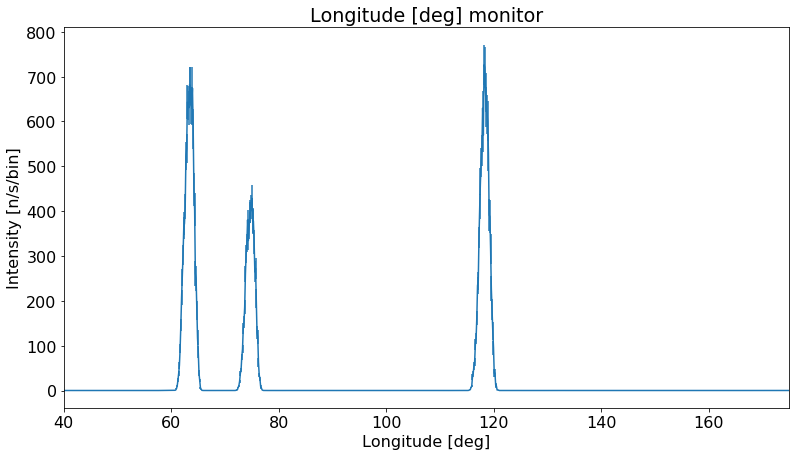

In [ ]:
plotter.make_sub_plot(data, fontsize=16)

The data "blob" returned by McStasScript contains the monitor data of the instrument as set set of numpy arrays.
To e.g. extract the energy resolved Effective Area of the telescope we may follow the proceudre outlined in Knudsen (2020). This simply requires us to divide the intensity histogram after the optic with an identical histogram before, and normalize by the illuminated area (in this case *1*).

To extract a single monitor's data from the data blob we use the function *name_search*.

In [ ]:
S_before = functions.name_search("emon0",data)
S_after = functions.name_search("emon1",data)
A_eff = numpy.divide(emon1,emon0)
#Plot it somehow